In [109]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Model, models
from tensorflow.keras.layers import Input, Conv2D, ReLU, Flatten, Dense, Reshape, Conv2DTranspose, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import pdb
from tensorflow.keras.optimizers import SGD,RMSprop
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

In [110]:
# folder_path = r'D:\MILCOM_2025\IQ_BIN_data_SNR-5'
# folder_path = r'D:\MILCOM_2025\IQ_BIN_data_SNR0'
# folder_path = r'D:\MILCOM_2025\IQ_BIN_data_SNR5'
# folder_path = r'D:\MILCOM_2025\IQ_SNR5'
# folder_path = r'D:\MILCOM_2025\IQ_SNR-5'
folder_path = r'D:\MILCOM_2025\IQ_SNR-5_binary'
# folder_path = r'D:\MILCOM_2025\IQ_SNR0'
# folder_path =r'D:\MILCOM_2025\Real_Data_BIN_Classification\BIN_Real_data'

In [112]:
save_dir = r"D:\MILCOM_2025\Results"

In [ ]:
# folder_path= r"D:\SDRChallenge-main\SDR_data\Raw_IQ_Values\SNR0\5G_Only\5G_Only_SNR0_BIN1_A (1).dat"
# folder_path= r"D:\SDRChallenge-main\Demo\IQ\numpy_data"
# folder_path = r"D:\SDRChallenge-main\Demo\IQ"
def load_npy_data(folder_path, label):
    data_list = []
    #c = 0  
    for subdir, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".npy"):
                file_path = os.path.join(subdir, file)
                data = np.load(file_path)  # Load the .npy file
                # print(data.shape)
                data = np.nan_to_num(data, nan=0.0) # Keep rows with no NaN value
                # print(data.shape)

                # Assuming data has I values in the first column and Q values in the second column
                I_values = data[:, 0]
                Q_values = data[:, 1]
                stacked_IQ_values = np.concatenate((I_values, Q_values), axis=0).reshape(-1, 1)
                # print(stacked_IQ_values.shape)
                transposed_IQ_values = stacked_IQ_values.T
                # print(transposed_IQ_values.shape)
                labeled_data = np.append(transposed_IQ_values, label).reshape(1, -1)
                              
                # Check for NaN or Inf values and handle them
                # if np.isnan(data).any() or np.isinf(data).any():
                #     data = np.nan_to_num(data)  # Replace NaN and Inf with 0
                # # Add labeled row to the data list
                data_list.append(labeled_data)
                # print(labeled_data.shape)
                # print(len(data_list))
    return np.vstack(data_list) if data_list else None
    # return np.vstack(data_list) if data_list else None
g5 = load_npy_data(os.path.join(folder_path, "5G"), label=0)
radar = load_npy_data(os.path.join(folder_path, "Radar"), label=1)
# radar_and_5G = load_npy_data(os.path.join(folder_path, "Radar_and_5G"), label=2)




In [7]:
# BIN1_A = load_npy_data(os.path.join(folder_path, "BIN1-A"), label=0)
# BIN1_B = load_npy_data(os.path.join(folder_path, "BIN1-B"), label=1)
# BIN2_A = load_npy_data(os.path.join(folder_path, "BIN2-A"), label=2)
# BIN2_B = load_npy_data(os.path.join(folder_path, "BIN2-B"), label=3)
# BIN3_A = load_npy_data(os.path.join(folder_path, "BIN3-A"), label=4)
# BIN3_B = load_npy_data(os.path.join(folder_path, "BIN3-B"), label=5)

In [115]:
# Combine data if available
# data_to_combine = [d for d in [BIN1_A, BIN1_B, BIN2_A,BIN2_B,BIN3_A,BIN3_B] if d is not None]
# data_to_combine = [d for d in [g5, radar, radar_and_5G] if d is not None]
data_to_combine = [d for d in [g5, radar] if d is not None]
# data_to_combine = [d for d in [radar_data, g5_data] if d is not None]
print(len(data_to_combine))
if data_to_combine:
    combined_data = np.vstack(data_to_combine)
    # Print shape of the combined data
    print(f"Combined data shape: {combined_data.shape}")
    # Display first few rows to verify the format
    print("First few rows of combined data:")
    print(combined_data[:5])
else:
    print("No data loaded from the specified folders.")

2
Combined data shape: (1512, 614401)
First few rows of combined data:
[[-3.40282347e+38 -3.40282347e+38 -3.40282347e+38 ... -3.40282347e+38
  -3.40282347e+38  0.00000000e+00]
 [-3.40282347e+38 -3.40282347e+38 -3.40282347e+38 ...  0.00000000e+00
  -3.40282347e+38  0.00000000e+00]
 [-3.40282347e+38 -3.40282347e+38  0.00000000e+00 ... -3.40282347e+38
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -3.40282347e+38
  -3.40282347e+38  0.00000000e+00]
 [ 0.00000000e+00 -3.40282347e+38 -3.40282347e+38 ...  0.00000000e+00
  -3.40282347e+38  0.00000000e+00]]


In [116]:
print(combined_data.shape)

(1512, 614401)


In [117]:
X = combined_data[:, :-1]  # Features (all columns except the last)
y = combined_data[:, -1]   # Labels (last column)

In [118]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [12]:
# # Save the scaler for later use
# joblib.dump(scaler, "scaler.pkl")
# print("Scaler saved successfully!")

##### Convert labels to one-hot encoding

In [119]:
y = to_categorical(y, num_classes=2)

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [ ]:
# Print the sizes of each set
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_test.shape[0]} samples")
# print(f"Test set: {X_test.shape[0]} samples")

Training set: 907 samples
Validation set: 605 samples


### ANN

In [18]:
print(X_train.shape[1],)

614400


In [122]:
model = tf.keras.Sequential([
    # Input layer
    tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),

    # Dense layers corresponding to Conv2D layers with similar progression in the number of neurons
    tf.keras.layers.Dense(16, activation='relu'),  # Similar to Conv2D(16)
    tf.keras.layers.Dense(32, activation='relu'),  # Similar to Conv2D(32)
    tf.keras.layers.Dense(64, activation='relu'),  # Similar to Conv2D(64)
    tf.keras.layers.Dense(128, activation='relu'), # Similar to Conv2D(128)

    # Flatten layer equivalent (not needed as Dense layers don't require flattening input)
    
    # First Dense layer
    tf.keras.layers.Dense(128, activation='relu'),  # Match the first dense layer in CNN

    # Second Dense layer, with softmax activation for classification
    tf.keras.layers.Dense(2, activation='softmax')  # Match the output layer
])


In [123]:
custom_lr = 0.0001 # Adjust the learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=custom_lr)


In [124]:
# Compile the model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [125]:
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/100
57/57 [==============================] - 4s 50ms/step - loss: 0.3373 - accuracy: 0.8456 - val_loss: 0.1132 - val_accuracy: 0.9884
Epoch 2/100
57/57 [==============================] - 1s 19ms/step - loss: 0.0658 - accuracy: 0.9746 - val_loss: 0.0771 - val_accuracy: 0.9884
Epoch 3/100
57/57 [==============================] - 1s 17ms/step - loss: 0.0072 - accuracy: 0.9978 - val_loss: 0.0750 - val_accuracy: 0.9868
Epoch 4/100
57/57 [==============================] - 1s 17ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0733 - val_accuracy: 0.9851
Epoch 5/100
57/57 [==============================] - 1s 14ms/step - loss: 9.8545e-04 - accuracy: 1.0000 - val_loss: 0.0667 - val_accuracy: 0.9884
Epoch 6/100
57/57 [==============================] - 1s 12ms/step - loss: 7.0132e-04 - accuracy: 1.0000 - val_loss: 0.0646 - val_accuracy: 0.9884
Epoch 7/100
57/57 [==============================] - 1s 14ms/step - loss: 5.4528e-04 - accuracy: 1.0000 - val_loss: 0.0627 - val_accuracy: 0

In [23]:
# model.save(r'D:\MILCOM_2025\ANN_SNR_Minus5.h5')

In [ ]:
# model = load_model(r'D:\MILCOM_2025\ANN_SNR_Minus5.h5')

19/19 [==============================] - 0s 11ms/step


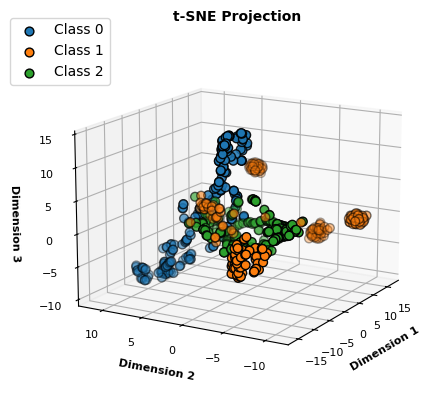

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
class_names = ['5G', 'Radar', 'Radar and 5G']
# Step 1: Define a feature extractor
feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)

# Step 2: Extract features from X_test
features = feature_extractor.predict(X_test)
labels = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test

# Step 3: Compute 3D t-SNE
tsne_3d = TSNE(n_components=3, perplexity=30, max_iter=1000, random_state=42).fit_transform(features)

# Step 4: Plot from 4 different angles
fig = plt.figure(figsize=(10, 8))
# angles = [(25, 45), (25, 135), (15, 210), (35, 300)]  # (elev, azim)
angles = [(15, 210)]  # (elev, azim)
palette = sns.color_palette("hsv", len(np.unique(labels)))

for i, (elev, azim) in enumerate(angles):
    ax = fig.add_subplot(2, 2, i + 1, projection='3d')
    for j in np.unique(labels):
        idx = labels == j
        ax.scatter(tsne_3d[idx, 0], tsne_3d[idx, 1], tsne_3d[idx, 2],
                   label=f'Class {j}', s=40, edgecolor='black')
    
    ax.view_init(elev=elev, azim=azim)
    # ax.set_title(f't-SNE View {i+1}: Elev={elev}°, Azim={azim}°', fontsize=11, fontweight='bold')
    ax.set_title("t-SNE Projection", fontsize=10, fontweight='bold')
    ax.set_xlabel("Dimension 1", fontsize=8, fontweight='bold')
    ax.set_ylabel("Dimension 2", fontsize=8, fontweight='bold')
    ax.set_zlabel("Dimension 3", fontsize=8, fontweight='bold')
    ax.tick_params(labelsize=8)

fig.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98), ncol=1, fontsize=10)

plt.tight_layout()
# plt.savefig(r"D:\MILCOM_2025\Results\tsne for ANN Radar Detection data.pdf", dpi=600, bbox_inches='tight')

plt.show()


19/19 [==============================] - 0s 15ms/step


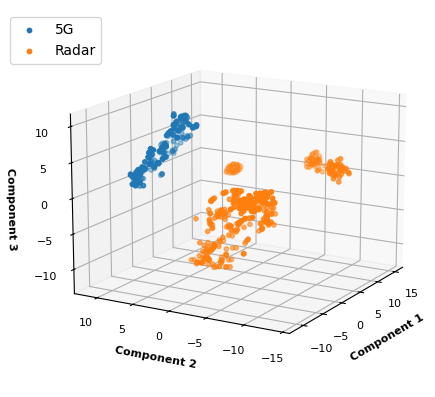

In [126]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf

# Step 1: Define custom class names
class_names = ['5G', 'Radar']

# Step 2: Define feature extractor
feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)

# Step 3: Extract features from X_test
features = feature_extractor.predict(X_test)
labels = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test

# Step 4: Compute 3D t-SNE
tsne_3d = TSNE(n_components=3, perplexity=30, max_iter=1000, random_state=42).fit_transform(features)

# Step 5: Plot
fig = plt.figure(figsize=(10, 8))
angles = [(15, 210)]  # Viewing angle
palette = sns.color_palette("hsv", len(np.unique(labels)))

for i, (elev, azim) in enumerate(angles):
    ax = fig.add_subplot(2, 2, i + 1, projection='3d')
    for j in np.unique(labels):
        idx = labels == j
        ax.scatter(tsne_3d[idx, 0], tsne_3d[idx, 1], tsne_3d[idx, 2],
                   label=class_names[j], s=10)  # ← updated label here

    ax.view_init(elev=elev, azim=azim)
    # ax.set_title("t-SNE Projection", fontsize=10, fontweight='bold')
    ax.set_xlabel("Component 1", fontsize=8, fontweight='bold')
    ax.set_ylabel("Component 2", fontsize=8, fontweight='bold')
    ax.set_zlabel("Component 3", fontsize=8, fontweight='bold')
    ax.tick_params(labelsize=8)

fig.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98), ncol=1, fontsize=10)
plt.tight_layout()
# plt.savefig(r"D:\MILCOM_2025\Results\tsne for ANN Radar Detection data.pdf", dpi=600, bbox_inches='tight')
plt.show()



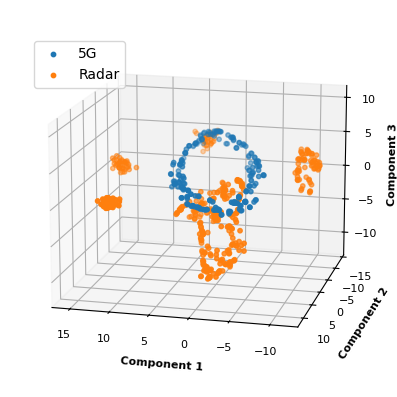

In [128]:

# Step 5: Plot
fig = plt.figure(figsize=(10, 8))
angles = [(15, 210)]  # Viewing angle
palette = sns.color_palette("hsv", len(np.unique(labels)))

for i, (elev, azim) in enumerate(angles):
    ax = fig.add_subplot(2, 2, i + 1, projection='3d')
    for j in np.unique(labels):
        idx = labels == j
        ax.scatter(tsne_3d[idx, 0], tsne_3d[idx, 1], tsne_3d[idx, 2],
                   label=class_names[j], s=10)  # ← updated label here

    ax.view_init(elev=15, azim=104)
    # ax.set_title("t-SNE Projection", fontsize=10, fontweight='bold')
    ax.set_xlabel("Component 1", fontsize=8, fontweight='bold')
    ax.set_ylabel("Component 2", fontsize=8, fontweight='bold')
    ax.set_zlabel("Component 3", fontsize=8, fontweight='bold')
    ax.tick_params(labelsize=8)

fig.legend(loc='upper left', bbox_to_anchor=(0.082, 0.95), ncol=1, fontsize=10)
plt.tight_layout()
plt.savefig(r"D:\MILCOM_2025\Results\tsne for ANN Radar Detection data_binary.pdf", dpi=600, bbox_inches='tight')
plt.show()


## Inference Time Calculation

In [104]:
import time
import numpy as np

# Pick one sample from the test set (reshape it to maintain batch dimension)
sample = X_test[0].reshape(1, -1)

# Warm-up
#_ = model.predict(sample, verbose=0)

# Run 1000 inferences and measure time
num_runs = 1
total_time = 0

for _ in range(num_runs):
    start_time = time.time()
    prediction = model.predict(sample, verbose=0)
    end_time = time.time()
    total_time += (end_time - start_time)

# Calculate average inference time
avg_inference_time_ms = (total_time / num_runs) * 1000
predicted_class = np.argmax(prediction)
true_class = np.argmax(y_test[0])

# Print results
print(f"✅ Predicted class: {predicted_class}")
print(f"✅ True class: {true_class}")
print(f"✅ Average inference time over {num_runs} runs: {avg_inference_time_ms:.4f} ms")


✅ Predicted class: 1
✅ True class: 1
✅ Average inference time over 1 runs: 39.8576 ms


In [ ]:
model.summary()